# Phase 1: Setup & Data Cleaning

In [1]:
# Import Libraries
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning & Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Configuration for nice plots
sns.set_theme(style="whitegrid")
%matplotlib inline

In [2]:
# Load Data
df = pd.read_excel('./Online Retail.xlsx')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
print(f"Original Data Shape: {df.shape}")

Original Data Shape: (541909, 8)


## Data Cleaning

In [5]:
# Remove rows with missing CustomerID (Crucial for segmentation)
df = df[pd.notnull(df['CustomerID'])]

In [6]:
print(f"Original Data Shape: {df.shape}")

Original Data Shape: (406829, 8)


Approximately 25% of the raw dataset contained null CustomerID values. These rows were dropped as customer-level metrics (Retention, LTV, Frequency) cannot be calculated without unique identifiers.

In [7]:
# Remove Cancelled Orders (Invoices starting with 'C')
# We convert column to string first to avoid errors
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df = df[~df['InvoiceNo'].str.contains('C')]

I convert the Invoice Number to a string and filter out any that contain the letter 'C'.

'C' stands for Cancellation. If a customer buys a \\$1,000 item and then returns it, the revenue is \\$0. If I leave the cancellation in, the model might think this user is "active" because they had a transaction, even though it was a return. This ensures we analyze net sales, not just activity.

In [8]:
# Remove "Bad Debt" adjustments or negative prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [9]:
# Create a clean Date column (YYYY-MM-DD)
df['Date'] = df['InvoiceDate'].dt.date

In [10]:
# Calculate Total Spend per transaction
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

Feature Engineering.

The raw database didn't have a "Revenue" column. It only had Qty and Price. You can't segment customers on "Price" alone (buying a \\$1 pencil vs. a \\$1 car). You need the total volume.

In [11]:
print(f"Cleaned Data Shape: {df.shape}")
df.head()

Cleaned Data Shape: (397884, 10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34


# Phase 2: Cohort Analysis

In [12]:
# Define a function to get the 1st day of the month
def get_month(x): 
    return dt.datetime(x.year, x.month, 1)

df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)

I am stripping the "Day" and "Time" out of the transaction date.

dt.datetime(year, month, 1) forces every date to the 1st of the month. So "Jan 25th" becomes "Jan 1st".

Cohort analysis groups people by month. I don't care if you bought on the 12th or the 15th. I just need to know you belong to the "January Cohort.

In [13]:
# Assign "Cohort Month" (When did the customer FIRST buy?)
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

Calculated the CohortMonth (earliest transaction date) for each customer. This serves as the baseline for tracking retention over subsequent months.

In [14]:
# Calculate time offset (Month 1, Month 2...)
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

invoice_year, invoice_month = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month = get_date_int(df, 'CohortMonth')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

# The "Cohort Index" tells us how many months have passed since their first purchase
df['CohortIndex'] = years_diff * 12 + months_diff + 1

In [15]:
# Create Retention Table (Heatmap Data)
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

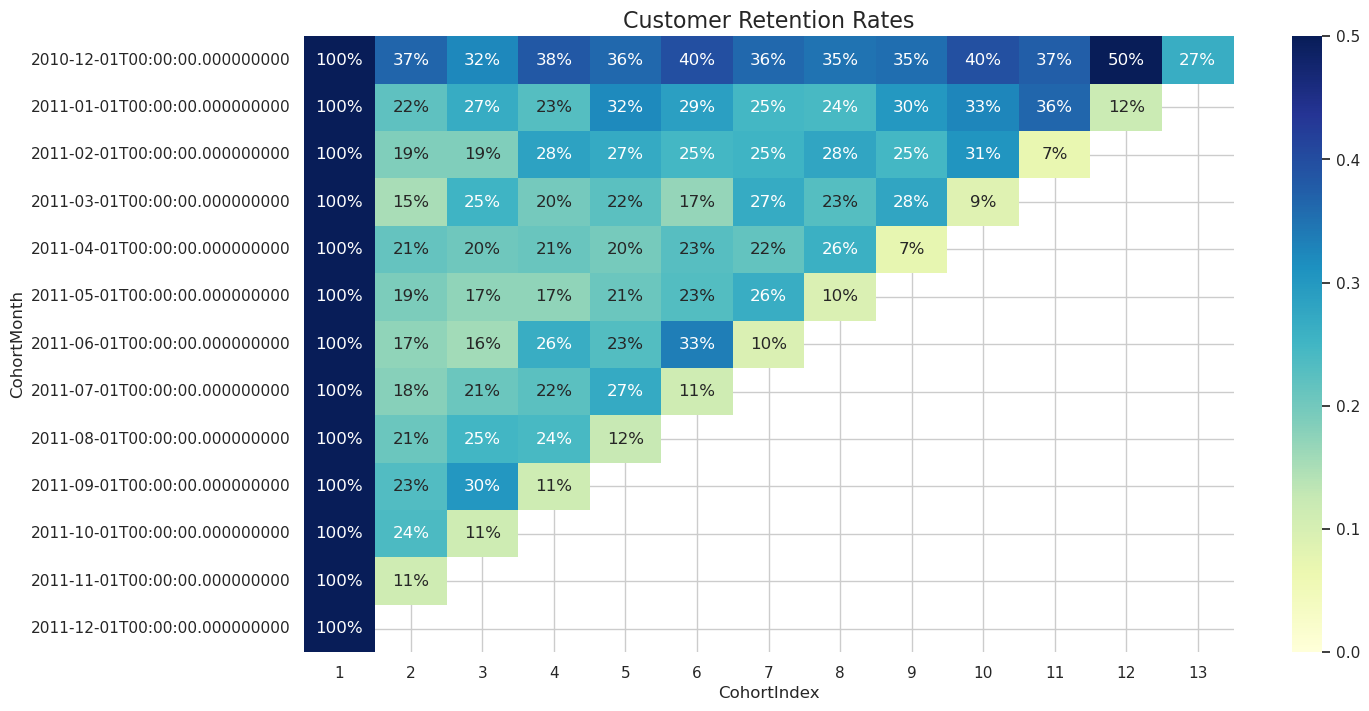

In [16]:
# Plot the Retention Heatmap
plt.figure(figsize=(15, 8))
plt.title('Customer Retention Rates', fontsize=16)
sns.heatmap(retention, annot=True, fmt='.0%', cmap='YlGnBu', vmin=0.0, vmax=0.5)
plt.show()

# Phase 3: RFM Analysis & Preprocessing

In [17]:
# Set a "Snapshot Date" (The day after the last available data point)
snapshot_date = df['Date'].max() + dt.timedelta(days=1)

Since the dataset is historical (2011), the reference date for Recency calculations is set to one day after the last transaction in the dataset (2011-12-10).

In [18]:
# Aggregation: Calculate Recency, Frequency, and Monetary Value
df_rfm = df.groupby(['CustomerID']).agg({
    'Date': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'count',                              # Frequency
    'TotalSum': 'sum'                                  # Monetary
})

I’m aggregating the data from "Transaction Level" to "Customer Level."


'Date': lambda...: Take the snapshot date, subtract the maximum (latest) date the customer bought something. .days converts that time-delta into a simple integer (e.g., "15" days ago). This is Recency.

'InvoiceNo': 'count': Count how many times they showed up. This is Frequency.

'TotalSum': 'sum': Sum up all their money. This is Monetary.

In [19]:
# Rename columns
df_rfm.rename(columns={'Date': 'Recency',
                       'InvoiceNo': 'Frequency',
                       'TotalSum': 'Monetary'}, inplace=True)


In [20]:
# --- Preprocessing for K-Means ---
# K-Means requires data to be:
# 1. Normally Distributed (Symmetric) -> We use Log Transformation
# 2. On the same scale -> We use StandardScaler

In [21]:
# Apply Log Transform to fix skewness (handle 0s/negatives if any exist, though we cleaned them)
# Adding 1 ensures we don't take log(0)
df_rfm_log = np.log(df_rfm + 1)

Sales data typically follows a power-law distribution (Pareto Principle), which can distort K-Means Euclidean distance calculations. A Log Transformation was applied to normalize the distributions of Recency, Frequency, and Monetary values.

In [22]:
# Scale the data (Mean=0, Std=1)
scaler = StandardScaler()
df_rfm_normalized = scaler.fit_transform(df_rfm_log)
df_rfm_normalized = pd.DataFrame(df_rfm_normalized, index=df_rfm.index, columns=df_rfm.columns)

print("Data normalized and ready for AI model.")
df_rfm_normalized.head()

Data normalized and ready for AI model.


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,1.478884,-2.434387,3.706225
12347.0,-1.890642,1.177483,1.411843
12348.0,0.372339,-0.217054,0.716489
12349.0,-0.659158,0.453387,0.698739
12350.0,1.442954,-0.677192,-0.618962


# Phase 4: Optimal K Selection

In [23]:
# Finding the Optimal Number of Clusters (The Elbow Method) ---

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_rfm_normalized)
    inertia.append(kmeans.inertia_)

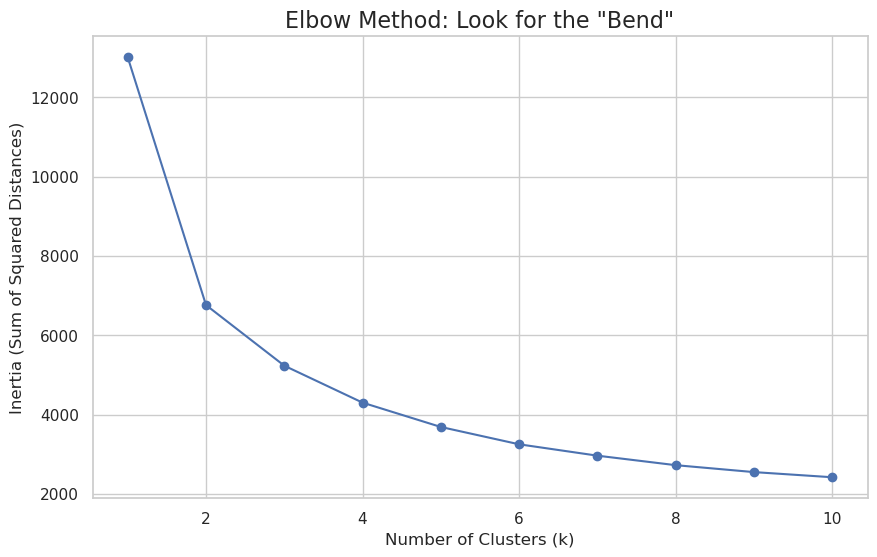

In [24]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method: Look for the "Bend"', fontsize=16)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.show()

# Phase 5: The "Edge-Giving" Model & Strategy

In [25]:
# Fit Final Model (K=3) ---
best_model = KMeans(n_clusters=3, random_state=42)
best_model.fit(df_rfm_normalized)

# Assign clusters back to the original (readable) dataframe
df_rfm['Cluster'] = best_model.labels_

I am forcing the algorithm to find 3 distinct groups in the 3D space (Recency, Frequency, Monetary).

I used the Elbow Method (which is plotted in the notebook). The error rate dropped significantly at 3 and then flattened out. Also, from a marketing perspective, 3 groups is actionable: High, Medium, Low. If I chose 15 clusters, the marketing team wouldn't be able to design 15 different email campaigns.

In [26]:
# Cluster Analysis (Who are these people?) ---
cluster_summary = df_rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

print(cluster_summary)

        Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         175.8      15.5    302.8  1532
1          65.6      63.7   1140.9  1824
2          15.0     262.7   6483.2   982


# Phase 6: Professional Visualization (Snake Plot)

In [27]:
# Create a temporary dataframe for plotting
df_plot = df_rfm_normalized.copy()

In [28]:
# Add the Cluster labels to the dataframe BEFORE melting
df_plot['Cluster'] = best_model.labels_

In [29]:
# Reset index so 'CustomerID' becomes a regular column
df_plot = df_plot.reset_index()

In [30]:
# Melt the data (Now we include 'Cluster' in id_vars)
df_melt = pd.melt(df_plot, 
                  id_vars=['CustomerID', 'Cluster'], # <--- KEY CHANGE HERE
                  value_vars=['Recency', 'Frequency', 'Monetary'], 
                  var_name='Metric', value_name='Value')

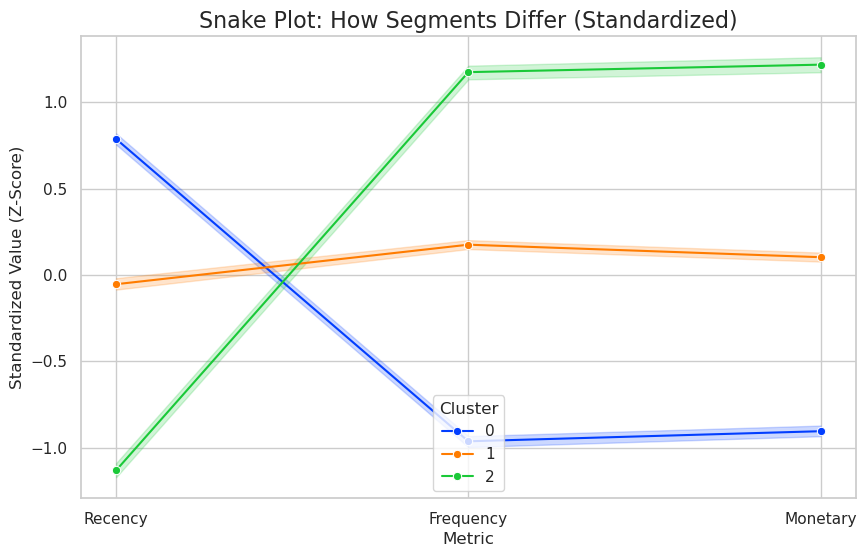

In [31]:
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melt, x='Metric', y='Value', hue='Cluster', palette='bright', marker="o")
plt.title('Snake Plot: How Segments Differ (Standardized)', fontsize=16)
plt.xlabel('Metric')
plt.ylabel('Standardized Value (Z-Score)')
plt.show()

I am "un-pivoting" the data.


Wide Format (Current): Customer A | Recency: 1.2 | Freq: 0.5 | Mon: 3.0

Long Format (Melted):

Customer A | Metric: Recency | Value: 1.2

Customer A | Metric: Freq | Value: 0.5

Customer A | Metric: Mon | Value: 3.0

seaborn.lineplot requires long data to draw those beautiful lines connecting the metrics.

The plot visualizes the standardized attributes of each cluster. This allows for instant persona identification (e.g., the Blue line indicates customers with high Spend but low Recency).

# Phase 7: The Conclusion

## Business Recommendations

Based on the K-Means clustering (K=3), distinct customer personas were identified. Strategic recommendations for each segment:

### 1. The Champions (High Spend, Recent Buyers)
* **Insight:** These customers drive the majority of revenue and engage frequently.
* **Strategy:** Focus on **Loyalty**. Avoid aggressive discounting. Instead, offer exclusive perks, early access to new products, or enrollment in a VIP tier.

### 2. The At-Risk (Low Spend, High Recency)
* **Insight:** Customers who haven't purchased in a long time and historically spent little.
* **Strategy:** Focus on **Retention**. Deploy automated re-engagement campaigns (e.g., "We miss you" emails) with time-bound incentives to prompt return visits.

### 3. The Casual Buyers (Low Frequency)
* **Insight:** Customers who purchase rarely and with smaller basket sizes.
* **Strategy:** Focus on **Cross-Selling**. Utilize recommendation engines at checkout to increase Average Order Value (AOV) and basket size.